In [113]:
import sys, os, json, pickle, gzip, copy, torch, numbers, tqdm
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.utils import ActiveElements, MetalElements, Element, AllElements
from src.utils import composit_parser
from src.feature import composition_to_feature

from pymatgen.core import Composition, Element

from scipy.stats import gaussian_kde
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

### fnc

In [2]:
def cyclical_kld_annealing(epochs, start=0, stop=1, n_cycle=4, ratio=0.5):
    '''
    Code from paper 'Cyclical Annealing Schedule: A Simple Approach to Mitigating KL Vanishing'
    arXiv: https://arxiv.org/abs/1903.10145
    github: https://github.com/haofuml/cyclical_annealing

    Scheduling KLD for better training of VAE.
    '''
    beta = np.ones(epochs)
    period = epochs / n_cycle
    step = (stop - start) / (period * ratio)
    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < epochs):
            beta[int(i+c*period)] = v
            v += step
            i += 1
    return beta

def test_kld_annealing(epochs, start=0, stop=1, n_cycle=4, ratio=0.5):
    beta = np.ones(epochs)
    period = epochs / n_cycle
    step = (stop - start) / (period * ratio)
    for i in range(int(period)):
        beta[i::int(period)] = start + step * i
    return np.clip(beta, start, stop)

def compute_accuracy(th, output):
    pred = torch.nn.Sigmoid()(torch.from_numpy(np.vstack(output['pred']))).numpy()
    label = np.vstack(output['label']).astype(bool)
    mask = np.vstack(output['label_mask'])
    n = 0
    rxn_ids = []
    for rxn_id in output['rxn_id']:
        rxn_ids.append(rxn_id + n - rxn_id.min())
        n = rxn_id.max() + 1
    rxn_ids = np.hstack(rxn_ids)
    by_rxn = []
    rxn = []
    lbls = []
    prds = []
    rxn_id = 0
    for _p, l, m, i in zip(pred, label, mask, rxn_ids):
        p = _p >= th
        if p[m].sum() == 0:
            p[m][_p[m].argmax()] = True
        _m = (p | l) & m
        lbls.append(l[_m])
        prds.append(p[_m])
        if i == rxn_id:
            rxn.append((l & p)[_m])
        else:
            by_rxn.append(np.hstack(rxn).mean() == 1)
            rxn = [(l & p)[_m]]
            rxn_id = i
    labels = np.hstack(lbls)
    preds = np.hstack(prds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    rxn_acc = np.hstack(by_rxn).mean()
    return precision, recall, f1, rxn_acc

def compute_accuracy_v2(output):
    pred_num = torch.from_numpy(np.vstack(output['pred_num'])).numpy().argmax(1)
    pred_lbl = torch.from_numpy(np.vstack(output['pred_label'])).numpy()
    label = np.vstack(output['label']).astype(bool)
    mask = np.vstack(output['label_mask'])
    n = 0
    rxn_ids = []
    for rxn_id in output['rxn_id']:
        rxn_ids.append(rxn_id + n - rxn_id.min())
        n = rxn_id.max() + 1
    rxn_ids = np.hstack(rxn_ids)
    out = {f'top_n+{i}':{} for i in range(6)}
    acc_num = np.mean(pred_num == label.sum(1))
    for p, n, l, m, i in zip(pred_lbl, pred_num, label, mask, rxn_ids):
        if i not in out['top_n+0'].keys():
            for j in range(6):
                out[f'top_n+{j}'][i] = []
        if m.sum() == 1:
            for j in range(6):
                out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], [True]])
        else:
            idxs = np.argsort(p)[::-1]
            for j in range(6):
                m1 = np.zeros_like(m)
                m1[idxs[:n+j]] = True
                out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], m1[l]])

    acc_prec = [np.hstack(list(vs.values())).mean() for vs in out.values()]
    acc_rxn =[np.mean([np.sum(v == 0) == 0 for v in vs.values()]) for vs in out.values()]
    return acc_num, acc_prec, acc_rxn

def compute_accuracy_v3(output):
    pred_has = torch.from_numpy(np.vstack(output['pred_has'])).numpy().argmax(1)
    pred_lbl = torch.from_numpy(np.vstack(output['pred_label'])).numpy()
    label = np.vstack(output['label']).astype(bool)
    label_mask = np.vstack(output['label_mask'])
    null_mask = np.vstack(output['is_null'])
    n = 0
    rxn_ids = []
    for rxn_id in output['rxn_id']:
        rxn_ids.append(rxn_id + n - rxn_id.min())
        n = rxn_id.max() + 1
    rxn_ids = np.hstack(rxn_ids)
    out = {f'top_n+{i}':{} for i in range(6)}
    acc_num = np.mean(pred_has == label.sum(1))
    for p, n, l, m, i in zip(pred_lbl, pred_num, label, label_mask, rxn_ids):
        if i not in out['top_n+0'].keys():
            for j in range(6):
                out[f'top_n+{j}'][i] = []
        if m.sum() == 1:
            for j in range(6):
                out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], [True]])
        else:
            idxs = np.argsort(p)[::-1]
            for j in range(6):
                m1 = np.zeros_like(m)
                m1[idxs[:n+j]] = True
                out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], m1[l]])

    acc_prec = [np.hstack(list(vs.values())).mean() for vs in out.values()]
    acc_rxn =[np.mean([np.sum(v == 0) == 0 for v in vs.values()]) for vs in out.values()]
    return acc_num, acc_prec, acc_rxn


ths = np.linspace(0.01, 0.99, 51)
output_collection = {}

### annealing

In [3]:
%timeit test_kld_annealing(10000)
%timeit cyclical_kld_annealing(10000)
#f, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
#axs[0].scatter(range(epochs), y1)
#axs[1].scatter(range(epochs), y2)
#axs[2].scatter(range(epochs), (np.abs(y1 - y2) > 1e-15).astype(float))


575 µs ± 557 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
709 µs ± 7.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Graph template model

In [192]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDSS = ReactionGraphDataset(feat_type='cgcnn')
GDSS.from_file('../data/screened_single_source_conditional_reaction.pkl.gz',
               heat_temp_key=('heat_temp','median'))

GDSM = ReactionGraphDataset(feat_type='cgcnn')
GDSM.from_file('../data/screened_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'))


# DS = ReactionDataset()
# DS.from_file('../data/screened_conditional_reaction.pkl.gz', 
#              heat_temp_key=('heat_temp','median'))

## MSE

In [426]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

#model = GraphConvolutionBlock(
#    input_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info,
#    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, 
#    hidden_dim=128, hidden_layers=4,
#    batch_norm=False, dropout=0.5,
#)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.MSELoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                        #  output_keys=['pred','kld','mu','log_var','z']
                        output_keys=['pred','kld','mu','log_var','z']
#                         output_keys=['pred',]
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        # x = _feat['condition'].to('cuda')
        # edge_attr = _feat['edge_attr'].to('cuda')
        # edge_index = _feat['edge_index'].to('cuda')
        # pred = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        # output = [pred.detach()]

        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        # output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        mask = _feat['label_mask'].to('cuda')
        pred = pred * mask
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')                
            mse_loss = self.crit(pred, label)[mask].mean() 
            loss = mse_loss + beta * kld.sum()
            return loss, output
            # alpha = (label[_feat['label_mask']] - 0.25).abs()
            # ce_loss = (self.crit(pred, feat['label']) * (feat['label_mask'] + 1e-4)).mean()
            # bce_loss = self.crit(pred, label)[_feat['label_mask']]
            # focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            # mse = torch.mean(torch.sum(torch.square(feat['x'] - pvec), -1))
            # loss = focal_loss + beta * kld.sum()
            # return loss.mean(), output
        else:
            return output

tr = TestTR(model, lr=1e-3)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   0.9388931   0.5234255   0.2808917 /     0.0063     0.0057
   1 ( 0) /   0.0372658   0.3507551   0.2041869 /     0.0042     0.0040
   2 ( 0) /   0.0253557   0.1432442   0.0886899 /     0.0016     0.0015
   3 ( 0) /   0.0214880   0.1247218   0.0761226 /     0.0014     0.0013
   4 ( 0) /   0.0190165   0.0869648   0.0591049 /     0.0009     0.0009
   5 ( 0) /   0.0171527   0.0911958   0.0606690 /     0.0010     0.0010
   6 ( 0) /   0.0164552   0.1938847   0.1215879 /     0.0022     0.0023
   7 ( 0) /   0.0156754   0.0716539   0.0507438 /     0.0007     0.0007
   8 ( 0) /   0.0149410   0.0505665   0.0405577 /     0.0005     0.0005
   9 ( 0) /   0.0146277   0.0528972   0.0402562 /     0.0005     0.0005
  10 ( 0) /   0.0139425   0.0483975   0.0390019 /     0.0004     0.0004
  11 ( 0) /   0.0136859   0.0375010   0.0321454 /     0.0003     0.0003
  12 ( 0) /   0.0136810   0.1132672   0.0758169 /     0.0012     0.0013
  13 ( 0) /   0.0133948   0.0668698   0.0485773 /     0.0007    

In [430]:
pred

array([[0.5       , 0.5       , 0.73226464, ..., 0.5       , 0.5       ,
        0.5       ],
       [0.6578573 , 0.55534637, 0.5084114 , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49999827, 0.54241455, 0.5       , ..., 0.5       , 0.4930467 ,
        0.5       ],
       ...,
       [0.5       , 0.49328747, 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.4934712 , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ]], dtype=float32)

0.41 0.8976202375917881
0.48 0.7241827798491287


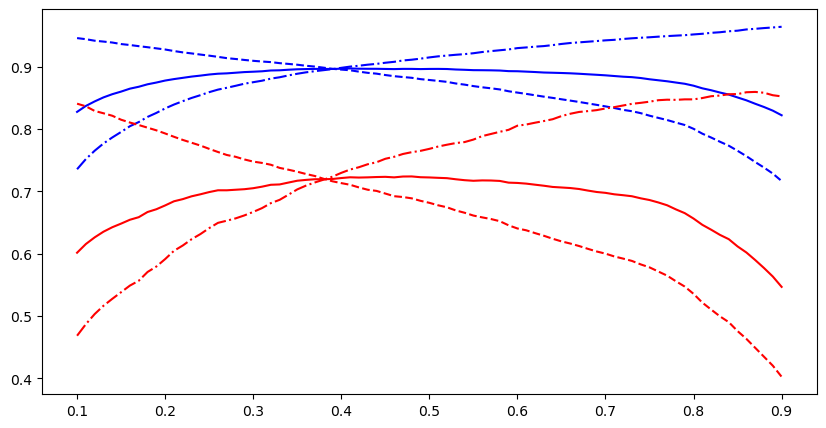

In [436]:
output = best_valid_output
pred = np.vstack(output['pred'])
mask = np.vstack(output['label_mask'])
label = np.vstack(output['label']).astype(bool)
n = 0
rxn_ids = []
for rxn_id in output['rxn_id']:
    rxn_ids.append(rxn_id + n - rxn_id.min())
    n += rxn_id.max() + 1
rxn_ids = np.hstack(rxn_ids)

out = {}
for th in np.linspace(0.1,0.9,81):
    out[f'{th:.3f}'] = {i:[[],[]] for i in np.unique(rxn_ids)}
    for p, l, m, i in zip(pred > th, label, mask, rxn_ids):
        out[f'{th:.3f}'][i][0] = np.hstack([out[f'{th:.3f}'][i][0], p[l & m]])
        out[f'{th:.3f}'][i][1] = np.hstack([out[f'{th:.3f}'][i][1], l[p & m]])
        
ths = np.array(list(out.keys())).astype(float)
acc_prec = np.array([np.hstack([v[0] for v in vs.values()]).mean() for vs in out.values()])
rec_prec = np.array([np.hstack([v[1] for v in vs.values()]).mean() for vs in out.values()])
f1_prec = 2 * acc_prec * rec_prec / (acc_prec + rec_prec)
acc_rxn = np.array([np.mean([np.mean(v[0]) == 1 for v in vs.values()]) for vs in out.values()])
rec_rxn = np.array([np.mean([np.mean(v[1]) == 1 if len(v[1]) != 0 else 0 for v in vs.values()]) for vs in out.values()])
f1_rxn = 2 * acc_rxn * rec_rxn / (acc_rxn + rec_rxn)

f, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ths, acc_prec, ls='--', color='b')
ax.plot(ths, rec_prec, ls='-.', color='b')
ax.plot(ths, f1_prec, color='b')
i = np.argmax(f1_prec)
print(ths[i], f1_prec[i])
ax.plot(ths, acc_rxn, ls='--', color='r')
ax.plot(ths, rec_rxn, ls='-.', color='r')
ax.plot(ths, f1_rxn, color='r')
i = np.argmax(f1_rxn)
print(ths[i], f1_rxn[i])


## BCE

In [423]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                         output_keys=['pred','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            label_mask = _feat['label_mask'].to('cuda')
            alpha = (label[label_mask] - 0.25).abs()
            bce_loss = self.crit(pred, label)[label_mask]
            focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            loss = focal_loss.mean() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-3)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   1.0799049   0.6260041   0.3309123 /     0.0077     0.0071
   1 ( 0) /   0.0338069   0.3679500   0.1963285 /     0.0045     0.0041
   2 ( 0) /   0.0203946   0.1670588   0.0927012 /     0.0020     0.0018
   3 ( 0) /   0.0164155   0.1879802   0.1089990 /     0.0023     0.0022
   4 ( 0) /   0.0136107   0.1943731   0.1148958 /     0.0023     0.0023
   5 ( 0) /   0.0120259   0.1028034   0.0630586 /     0.0012     0.0012
   6 ( 0) /   0.0108421   0.0985214   0.0626626 /     0.0011     0.0012
   7 ( 0) /   0.0098842   0.0886832   0.0570046 /     0.0010     0.0010
   8 ( 0) /   0.0086355   0.0665830   0.0440142 /     0.0007     0.0008
   9 ( 0) /   0.0083056   0.0733751   0.0485229 /     0.0008     0.0008
  10 ( 0) /   0.0077454   0.0768571   0.0509169 /     0.0009     0.0009
  11 ( 0) /   0.0075020   0.0644767   0.0442652 /     0.0007     0.0007
  12 ( 0) /   0.0069568   0.0593555   0.0412289 /     0.0006     0.0007
  13 ( 0) /   0.0065162   0.0911350   0.0602264 /     0.0010    

0.57 0.8882890525585162
0.57 0.7066187348195244


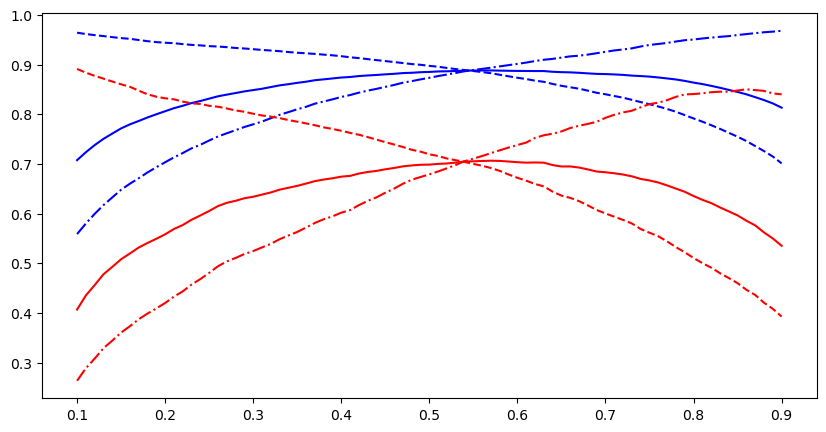

In [425]:
output = best_valid_output
pred = torch.nn.functional.sigmoid(torch.tensor(np.vstack(output['pred']))).numpy()
mask = np.vstack(output['label_mask'])
label = np.vstack(output['label']).astype(bool)
n = 0
rxn_ids = []
for rxn_id in output['rxn_id']:
    rxn_ids.append(rxn_id + n - rxn_id.min())
    n += rxn_id.max() + 1
rxn_ids = np.hstack(rxn_ids)

out = {}
for th in np.linspace(0.1,0.9,81):
    out[f'{th:.3f}'] = {i:[[],[]] for i in np.unique(rxn_ids)}
    for p, l, m, i in zip(pred > th, label, mask, rxn_ids):
        out[f'{th:.3f}'][i][0] = np.hstack([out[f'{th:.3f}'][i][0], p[l & m]])
        out[f'{th:.3f}'][i][1] = np.hstack([out[f'{th:.3f}'][i][1], l[p & m]])
        
ths = np.array(list(out.keys())).astype(float)
acc_prec = np.array([np.hstack([v[0] for v in vs.values()]).mean() for vs in out.values()])
rec_prec = np.array([np.hstack([v[1] for v in vs.values()]).mean() for vs in out.values()])
f1_prec = 2 * acc_prec * rec_prec / (acc_prec + rec_prec)
acc_rxn = np.array([np.mean([np.mean(v[0]) == 1 for v in vs.values()]) for vs in out.values()])
rec_rxn = np.array([np.mean([np.mean(v[1]) == 1 if len(v[1]) != 0 else 0 for v in vs.values()]) for vs in out.values()])
f1_rxn = 2 * acc_rxn * rec_rxn / (acc_rxn + rec_rxn)

f, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(ths, acc_prec, ls='--', color='b')
ax.plot(ths, rec_prec, ls='-.', color='b')
ax.plot(ths, f1_prec, color='b')
i = np.argmax(f1_prec)
print(ths[i], f1_prec[i])
ax.plot(ths, acc_rxn, ls='--', color='r')
ax.plot(ths, rec_rxn, ls='-.', color='r')
ax.plot(ths, f1_rxn, color='r')
i = np.argmax(f1_rxn)
print(ths[i], f1_rxn[i])


## CE - single

In [208]:
years = np.array([d.year for d in GDSS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSS, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSS.cfn)
valid_dl = DataLoader(GDSS, batch_size=2048, sampler=valid_idx, collate_fn=GDSS.cfn)
test_dl = DataLoader(GDSS, batch_size=2048, sampler=test_idx, collate_fn=GDSS.cfn)

model = GraphCVAE(
    input_dim=GDSS.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSS.num_meta_feat + GDSS.has_temp_info + GDSS.has_time_info, 
    edge_dim=GDSS.num_edge_feat, output_dim=GDSS.NUM_LABEL + 1, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss()):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight','is_null'],
                         output_keys=['pred_has','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        _pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask_label = _feat['label_mask'].to('cuda')
        mask_null  = _feat['is_null'].to('cuda')
        pred_has = torch.nn.functional.sigmoid(_pred[:, 0]) * mask_null
        pred_lbl = _pred[:, 1:] * mask_label
        output = [pred_has.detach(), pred_lbl.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        # case 1 - fast calc
        if compute_loss:
            label = _feat['label'].to('cuda')
            mask_prec = label.sum(1) != 0
            loss_bce = torch.nn.BCELoss()(pred_has[mask_null], label.sum(1)[mask_null])
            loss_ce = self.crit(pred_lbl[mask_prec], torch.where(label)[1])
            loss = loss_bce + loss_ce + beta * kld.sum()
            return loss, output
        else:
            return output

        # ## case 2 - reconstruction - too bad
        # if compute_loss:
        #     label = _feat['label'].to('cuda')
        #     mask_prec = label.sum(1) != 0
        #     loss_bce = torch.nn.BCELoss()(pred_has[mask_null], label.sum(1)[mask_null])
        #     loss_ce = 0
        #     for p, l, m1, m2 in zip(pred_lbl, label, mask_label, mask_prec):
        #         if not m2: continue
        #         loss_ce += self.crit(p[m1], l[m1])
        #     loss = loss_bce + loss_ce / mask_prec.sum() + beta * kld.sum()
        #     return loss, output
        # else:
        #     return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 50:
        pass
    if valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 25:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   8.1187028  10.0408357   8.5734241 /     0.1271     0.1203
   1 ( 0) /   1.5514278   4.4051005   3.8453529 /     0.0529     0.0507
   2 ( 0) /   1.0084581   2.8389723   2.5122638 /     0.0324     0.0312
   3 ( 0) /   0.7903049   1.8346564   1.6503854 /     0.0191     0.0183
   4 ( 0) /   0.6682529   1.4313140   1.3110480 /     0.0140     0.0133
   5 ( 0) /   0.5949574   1.1589914   1.0761124 /     0.0105     0.0100
   6 ( 0) /   0.5468470   1.0020020   0.9505779 /     0.0086     0.0083
   7 ( 0) /   0.5153497   0.8548245   0.8259104 /     0.0067     0.0064
   8 ( 0) /   0.4881925   0.7742648   0.7560272 /     0.0056     0.0054
   9 ( 0) /   0.4685414   0.7334938   0.7280240 /     0.0053     0.0052
  10 ( 0) /   0.4496546   0.7002250   0.6936353 /     0.0048     0.0047
  11 ( 0) /   0.4371906   0.6230292   0.6225970 /     0.0038     0.0037
  12 ( 0) /   0.4228687   0.5696634   0.5787181 /     0.0031     0.0030
  13 ( 0) /   0.4147672   0.5643713   0.5789987 /     0.0030    

In [209]:
output = best_valid_output

pred_has = torch.from_numpy(np.hstack(output['pred_has'])).numpy()
pred_lbl = torch.from_numpy(np.vstack(output['pred_label'])).numpy()
label = np.vstack(output['label']).astype(bool)
label_mask = np.vstack(output['label_mask'])
null_mask = np.hstack(output['is_null'])
n = 0
rxn_ids = []
for rxn_id in output['rxn_id']:
    rxn_ids.append(rxn_id + n - rxn_id.min())
    n += rxn_id.max() + 1
rxn_ids = np.hstack(rxn_ids)
out = {f'top_n+{i}':{} for i in range(6)}
prec_mask = ~null_mask | (pred_has > 0.38)
acc_null = ((pred_has[null_mask] > 0.38) == label[null_mask].sum(1).astype(bool)).mean()
for p, l, m1, m2, i in zip(pred_lbl, label, label_mask, prec_mask, rxn_ids):
    if i not in out['top_n+0'].keys():
        for j in range(6):
            out[f'top_n+{j}'][i] = []
    if (not m2) and (l.sum() == 0):
        continue
    elif ((not m2) and (l.sum() != 0)) or (m2 and (l.sum() == 0)):
        for j in range(6):
            out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], [False]])
        continue
    idxs = np.argsort(p)[::-1]
    _p = np.zeros_like(p, dtype=bool)
    for j in range(6):
        _p[idxs[j]] = True
        hit = l[_p].sum() != 0
        out[f'top_n+{j}'][i] = np.hstack([out[f'top_n+{j}'][i], [hit]])

acc_prec = [np.hstack(list(vs.values())).mean() for vs in out.values()]
acc_rxn =[np.mean([np.sum(v == 0) == 0 for v in vs.values()]) for vs in out.values()]
acc_null, acc_prec, acc_rxn


(0.9905405405405405,
 [0.9070278184480234,
  0.9608955588091752,
  0.9787701317715959,
  0.9874938994631528,
  0.9924353343094192,
  0.9942044899951196],
 [0.7646718146718147,
  0.8915057915057915,
  0.9393822393822394,
  0.965057915057915,
  0.9787644787644788,
  0.983011583011583])

In [210]:
def tester(idxs, values):
    if len(idxs) == 0:
        return [[]], [1]
    current_idx, remainder_idxs = idxs[0], idxs[1:]
    current_value, remainder_values = values[0], values[1:]
    set_idxs, set_values = tester(remainder_idxs, remainder_values)
    result_idxs = []
    result_values = []
    for i1, v1 in zip(current_idx, current_value):
        for i2, v2 in zip(set_idxs, set_values):
            result_idxs.append([i1] + i2)
            result_values.append(v1 + v2)
    return result_idxs, result_values

scored = {}
ns = {}
for i in tqdm.tqdm(sorted(np.unique(rxn_ids))):
    m0 = (i == rxn_ids) & prec_mask
    idxs = [np.argsort(pval)[::-1][:10] for pval in pred_lbl[m0]]
    pvals = [v[i][v[i] > 0] for v, i in zip(pred_lbl[m0], idxs)]
    tops = [i[v[i] > 0] for v, i in zip(pred_lbl[m0], idxs)]
    pred, score = tester(tops, pvals)
    pred_ = [p for p, s in sorted(zip(pred, score), key=lambda x: x[1], reverse=True)]
    score_ = [s for p, s in sorted(zip(pred, score), key=lambda x: x[1], reverse=True)]
    true_label = np.where(label[m0])[1]
    n = len(true_label)
    if n not in ns.keys():
        ns[n] = 0
    ns[n] += 1
    if len(pred_[0]) != len(true_label):
        scored[i] = [-2,-2]
        continue
    has_hit = False
    for j, (p, s) in enumerate(zip(pred, score_)):
        if (np.array(p) != true_label).sum() == 0:
            scored[i] = [j, s]
            has_hit = True
            break
    if not has_hit:
        scored[i] = [-1, -1]

100%|██████████| 5180/5180 [00:05<00:00, 997.00it/s] 


In [211]:
rank, score = np.array(list(scored.values())).T
l, c = np.unique(rank, return_counts=True)
_v = 0
for _l, _c in zip(l, c/c.sum()):
    if _l > -1: _v += _c * 100
    print('{:4.0f} : {:10.6f} ({:6.2f})'.format(_l, _c * 100, _v))


  -2 :   0.637066 (  0.00)
  -1 :   0.096525 (  0.00)
   0 :  76.602317 ( 76.60)
   1 :   5.057915 ( 81.66)
   2 :   2.200772 ( 83.86)
   3 :   1.196911 ( 85.06)
   4 :   0.656371 ( 85.71)
   5 :   0.694981 ( 86.41)
   6 :   1.196911 ( 87.61)
   7 :   0.308880 ( 87.92)
   8 :   0.250965 ( 88.17)
   9 :   0.173745 ( 88.34)
  10 :   0.656371 ( 89.00)
  11 :   0.173745 ( 89.17)
  12 :   0.347490 ( 89.52)
  13 :   0.231660 ( 89.75)
  14 :   0.308880 ( 90.06)
  15 :   0.366795 ( 90.42)
  16 :   0.250965 ( 90.68)
  17 :   0.077220 ( 90.75)
  18 :   0.193050 ( 90.95)
  19 :   0.038610 ( 90.98)
  20 :   0.308880 ( 91.29)
  21 :   0.463320 ( 91.76)
  23 :   0.019305 ( 91.78)
  24 :   0.386100 ( 92.16)
  25 :   0.077220 ( 92.24)
  26 :   0.019305 ( 92.26)
  27 :   0.019305 ( 92.28)
  28 :   0.135135 ( 92.41)
  29 :   0.135135 ( 92.55)
  30 :   0.463320 ( 93.01)
  31 :   0.193050 ( 93.20)
  32 :   0.173745 ( 93.38)
  33 :   0.038610 ( 93.42)
  35 :   0.115830 ( 93.53)
  36 :   0.057915 ( 93.59)
 

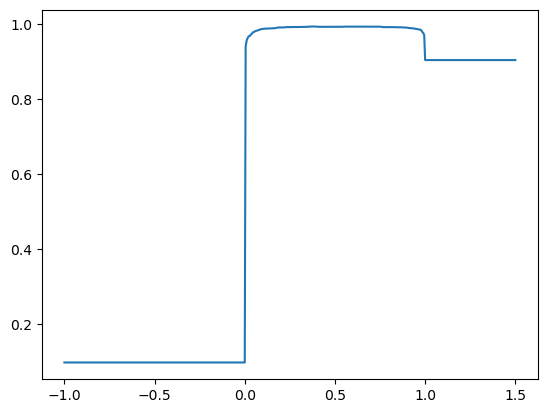

In [86]:
ths = np.linspace(-1, 1.5, 501)
y = [((pred_has[null_mask] > th) == label[null_mask].sum(1).astype(bool)).mean() for th in ths]
plt.plot(ths, y)

## CE - multi

In [465]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL + 5, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss()):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                         output_keys=['pred_num','pred_label','kld','mu','log_var','z']
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        mask = _feat['label_mask'].to('cuda')
        pred_num = pred[:, :5]
        pred_label = torch.nn.functional.sigmoid(pred[:, 5:]) * mask

        output = [pred_num.detach(), pred_label.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            label_num = label.sum(1).long()
            loss_num = self.crit(pred_num, label_num)

            _idx, _lbl = torch.where(label)
            loss_label = self.crit(pred_label[_idx], _lbl)
            loss = loss_num + loss_label + beta * kld.sum()

#             loss_label = 0
#             for p, l, m in zip(pred_label, label, mask):
#                 idxs = torch.where(l)[0]
#                 for i, j in enumerate(torch.where(l[m])[0]):
#                     _m = m.clone()
# #                    _m[idxs[:n]] = False
#                     _m = m.clone()
#                     _m[idxs] = False
#                     _m[idxs[i]] = True

#                     loss_label += self.crit((p * _m)[m], j)
#            loss = loss_num + loss_label / label_num.sum() + beta * kld.sum()
            return loss, output
        else:
            return output

tr = TestTR(model, lr=1e-4)
best_valid_loss = 1e5
count = 0
for i, beta in enumerate(test_kld_annealing(1000, start=1e-5, stop=0.1)):
    train_loss = tr.train(train_dl, beta)
    valid_loss, valid_output = tr.test(valid_dl, beta)
    test_loss, test_output = tr.test(test_dl, beta)
    if i < 20:
        pass
    elif valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    else:
        count += 1
    if count > 20:
        break
    print('{:4d} ({:2d}) /  {:10.7f}  {:10.7f}  {:10.7f} / {:10.4f} {:10.4f}'.format(
        i, count, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 ( 0) /   8.0842427  12.9452844   7.9747834 /     0.1120     0.0889
   1 ( 0) /   4.2797752   7.9734719   5.6191902 /     0.0519     0.0400
   2 ( 0) /   3.9728763   6.0239859   4.7345600 /     0.0283     0.0216
   3 ( 0) /   3.8432885   5.2191930   4.3616245 /     0.0185     0.0137
   4 ( 0) /   3.7787742   4.8438532   4.1933798 /     0.0142     0.0106
   5 ( 0) /   3.7397087   4.5172293   4.0498199 /     0.0102     0.0077
   6 ( 0) /   3.7161588   4.2714851   3.9478668 /     0.0073     0.0057
   7 ( 0) /   3.7014814   4.1962912   3.9068296 /     0.0065     0.0050
   8 ( 0) /   3.6886532   4.2018576   3.9020373 /     0.0065     0.0050
   9 ( 0) /   3.6791164   4.0458288   3.8282905 /     0.0047     0.0036
  10 ( 0) /   3.6714801   3.9996622   3.8207544 /     0.0042     0.0033
  11 ( 0) /   3.6651983   3.9579625   3.7877600 /     0.0037     0.0027
  12 ( 0) /   3.6588069   3.9335225   3.7878218 /     0.0035     0.0027
  13 ( 0) /   3.6549408   3.9559666   3.8105291 /     0.0038    

In [467]:
print(np.mean(np.vstack(best_valid_output['pred_num']).argmax(1) == np.vstack(best_valid_output['label']).sum(1)))

np.vstack(best_valid_output['pred_label'])
        #  == np.vstack(best_valid_output['label']).sum(1))

0.9884871491692078


array([[0.0000000e+00, 0.0000000e+00, 9.9999666e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9981862e-01, 9.9999309e-01, 9.9999154e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.1429753e-01, 9.9768686e-01, 0.0000000e+00, ..., 0.0000000e+00,
        2.5576359e-02, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.8892824e-03, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 7.2705814e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [468]:
compute_accuracy_v2(best_valid_output)

(0.9884871491692078,
 [0.8791385652973636,
  0.9515634580012262,
  0.977161250766401,
  0.9876609442060086,
  0.9939454322501533,
  0.9954015941140405],
 [0.6650717703349283,
  0.8506113769271664,
  0.9258373205741627,
  0.9582668793195109,
  0.9797979797979798,
  0.9843168527379054])

# non-graph / Multi / BCE

In [469]:
from src.data import ReactionDataset
from src.networks import CVAE
from src.trainer import VAETrainer, BaseTrainer

DSS = ReactionDataset(feat_type='cgcnn')
DSS.from_file('../data/screened_single_source_conditional_reaction.pkl.gz',
               heat_temp_key=('heat_temp','median'))

DSM = ReactionDataset(feat_type='cgcnn')
DSM.from_file('../data/screened_conditional_reaction.pkl.gz', 
               heat_temp_key=('heat_temp','median'))


# DS = ReactionDataset()
# DS.from_file('../data/screened_conditional_reaction.pkl.gz', 
#              heat_temp_key=('heat_temp','median'))

In [ ]:
years = np.array([d.year for d in GDSM])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDSM, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDSM.cfn)
valid_dl = DataLoader(GDSM, batch_size=2048, sampler=valid_idx, collate_fn=GDSM.cfn)
test_dl = DataLoader(GDSM, batch_size=2048, sampler=test_idx, collate_fn=GDSM.cfn)

model = GraphCVAE(
    input_dim=GDSM.num_precursor_feat, latent_dim=16, 
    condition_dim=GDSM.num_meta_feat + GDSM.has_temp_info + GDSM.has_time_info, 
    edge_dim=GDSM.num_edge_feat, output_dim=GDSM.NUM_LABEL + 5, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

# Legacy model

- Target: precursor composition w/o fraction (just element)
- Task: Reg / Cls -> classification is better
- Representation: FCNN / Graph Conv / Graph Att

## loading reference data

In [225]:
root_f = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_FCNN'
root_g = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_graph'
root_t = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_test'

with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)    

- test: year > 2018
- train: year < 2017



In [85]:
unique_reaction[0]

{'id': 0,
 'count': 1,
 'year': 1979,
 'target_comp': {'Y': 0.0020005717,
  'Al': 0.054872826,
  'Si': 0.37153473,
  'N': 0.5144327,
  'O': 0.057159193},
 'precursor_comp': [{'Y': 0.4, 'O': 0.6},
  {'Si': 0.33333334, 'O': 0.6666667},
  {'Al': 0.5, 'N': 0.5},
  {'Si': 0.42857143, 'N': 0.5714286}],
 'dois': ['10.1007/bf00549308'],
 'heat_temp': [{'mean': None, 'median': None, 'raw': []}],
 'heat_time': [{'mean': None, 'median': None, 'raw': []}]}

In [91]:
counter = {}
for rxn in unique_reaction:
    i = int(rxn['year'] > 2016) + int(rxn['year'] > 2018)
#    print(rxn['year'], i)
    for p in rxn['precursor_comp']:
        eles = '-'.join(sorted(p.keys(), key=lambda x: Element(x).number))
        if eles not in counter.keys():
            counter[eles] = [0, 0, 0]
        counter[eles][i] += 1
counter = {k:v for k,v in sorted(counter.items(), key=lambda x: np.sum(x[1]), reverse=True)}

In [92]:
counter

{'O-Ti': [3648, 720, 537],
 'C-O-Sr': [3565, 557, 368],
 'C-O-Ba': [3421, 572, 341],
 'O-La': [3362, 527, 292],
 'O-Fe': [2907, 545, 365],
 'C-O-Ca': [3026, 471, 305],
 'O-Bi': [2146, 513, 262],
 'O-Mn': [2431, 280, 187],
 'O-Nb': [1864, 357, 286],
 'O-Co': [1704, 284, 137],
 'O-Zn': [1573, 307, 186],
 'O-Y': [1599, 256, 184],
 'O-Si': [1538, 328, 162],
 'Li-C-O': [1417, 308, 207],
 'O-Al': [1249, 330, 266],
 'O-Cu': [1551, 188, 87],
 'C-O-Na': [1231, 366, 217],
 'O-Zr': [1141, 313, 141],
 'O-Eu': [1010, 277, 127],
 'O-Mg': [964, 271, 171],
 'O-Ce': [961, 208, 120],
 'Cu': [796, 254, 103],
 'O-Pb': [901, 129, 55],
 'O-Ni': [861, 136, 86],
 'O-Gd': [765, 211, 62],
 'Sb': [620, 281, 125],
 'O-Ga': [730, 178, 111],
 'O-Mo': [789, 122, 99],
 'Se': [586, 294, 109],
 'Te': [611, 266, 101],
 'O-Ta': [697, 115, 109],
 'Ni': [682, 143, 66],
 'O-Nd': [706, 108, 75],
 'H-N-O-P': [668, 189, 18],
 'O-W': [663, 110, 100],
 'O-Cr': [609, 125, 75],
 'C-O-Mn': [634, 96, 65],
 'S': [507, 203, 77],
 'O-S

## loading results in VAE_test directory

In [55]:
output = {}
for dir in os.listdir(os.path.join(root_t, 'cls')):
    if not os.path.isfile(os.path.join(root_t, 'cls', dir, 'output.valid.pkl')): continue
    output[dir] = {
        'test' :pickle.load(open(os.path.join(root_t, 'cls', dir, 'output.test.pkl'), 'rb')),
        'valid':pickle.load(open(os.path.join(root_t, 'cls', dir, 'output.valid.pkl'), 'rb')),
    }

- label - composition mapper

In [216]:
from src.utils import composit_parser


label_comp_mapper = {}
target_precursor_comps = {'test':[], 'valid':[]}
for ds in ['test','valid']:
    for lbl, info in zip(output['fcnn_elemnet_batch_0128_mdim_16_256_6'][ds]['label'], 
                         output['fcnn_elemnet_batch_0128_mdim_16_256_6'][ds]['info']):
        if lbl not in label_comp_mapper.keys():
            label_comp_mapper[lbl] = '-'.join(sorted(info['precursor_comp'].keys(), key=lambda x: Element(x).number))
        target_precursor_comps[ds].append(composit_parser(info['precursor_comp']))
label_comp_mapper.update({
    v:k for k,v in label_comp_mapper.items()
})

In [106]:
performance = {}
predictions = {}
targets = {}
for model, out in output.items():
    archi = model.split('_')[0]
    if archi not in performance.keys():
        performance[archi] = []
    valid_prd = out['valid']['pred'].argmax(1)
    valid_lbl = out['valid']['label']
    test_prd = out['test']['pred'].argmax(1)
    test_lbl = out['test']['label']
    
    performance[archi].append([
        f1_score(valid_lbl, valid_prd, average='micro'),
        f1_score(valid_lbl, valid_prd, average='macro'),
        f1_score(test_lbl, test_prd, average='micro'),
        f1_score(test_lbl, test_prd, average='macro'),
        model,
    ])

    predictions[model] = {
        'valid':valid_prd,
        'test':test_prd,
    }

    targets['valid'] = valid_lbl
    targets['test'] = test_lbl


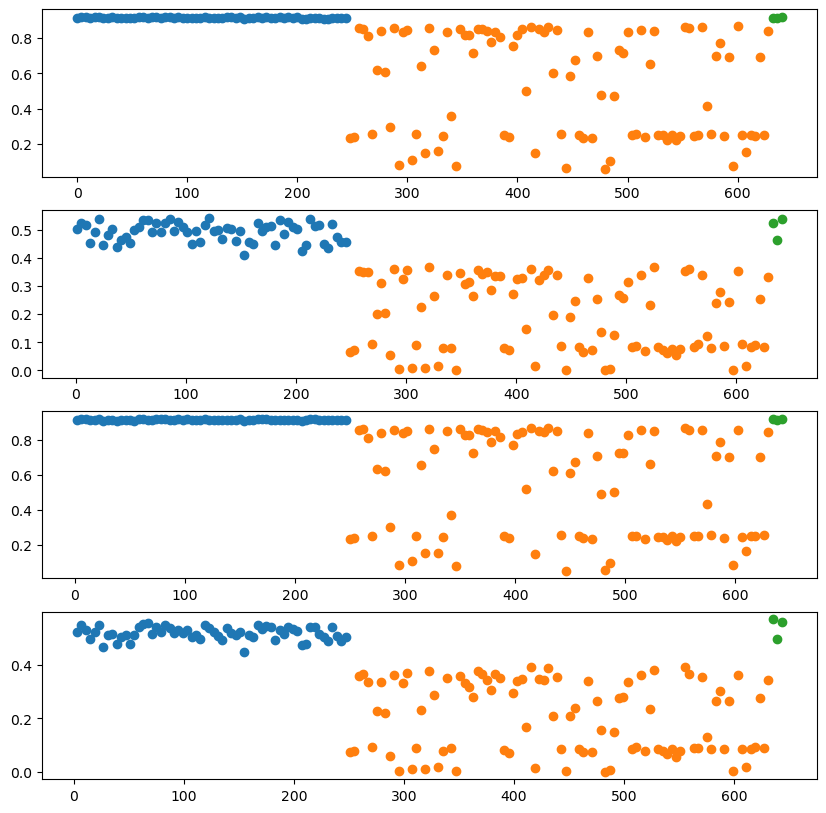

In [99]:
f, axs = plt.subplots(4,1,figsize=(10,10))
j = 0
for i, (archi, data) in enumerate(performance.items()):
    for dps in data:
        for ax, dp in zip(axs, dps[:4]):
            ax.scatter(j, dp, color=plt.cm.tab10(i))
            j += 1

In [105]:
print('Best performers: ')
for k, vs in performance.items():
    print(k, ' : ',[v[-1] for v in sorted(vs, key=lambda x: np.sum(x[:4]))][-1])

Best performers: 
fcnn  :  fcnn_active_composit_batch_0128_mdim_08_128_2
attention  :  attention_mat2vec_batch_0128_mdim_08_256_2
convolution  :  convolution_oliynyk_batch_0128_mdim_08_128_2


In [204]:
mat = {}
dct = {}
for comp, count in counter.items():
    if comp not in label_comp_mapper.keys(): continue
    i = label_comp_mapper[comp]
    s1 = '{:10s} | {:4d} tr | '.format(comp, count[0])
    s2 = '{:10s} | {:4d} v  | '.format('', count[1])
    s3 = '{:10s} | {:4d} te | '.format('', count[2])
    for s, archi, model in zip([s1, s2, s3], ['FC','GA','GC'],
                               ['fcnn_active_composit_batch_0128_mdim_08_128_2',
                                'attention_mat2vec_batch_0128_mdim_08_256_2',
                                'convolution_oliynyk_batch_0128_mdim_08_128_2',]):
        if archi not in mat.keys():
            mat[archi] = {}
            dct[archi] = {}
        s += '{:2s} | '.format(archi)
        for ds in ['valid','test']:
            if ds not in mat[archi].keys():
                mat[archi][ds] = []
                dct[archi][ds] = {}
            m1 = targets[ds] == i
            m2 = predictions[model][ds] == i
            if m1.sum() == 0:
                s += '{:34} | '.format('')
                mat[archi][ds].append([comp, m1.sum(), 0, 0, 0])
                continue
            tp = (m1 & m2).sum()
            tn = (~m1 & ~m2).sum()
            fp = (~m1 & m2).sum()
            fn = (m1 & ~m2).sum()
            prec = tp / (tp + fp) if tp + fp != 0 else 0
            rec = tp / (tp + fn) if tp + fn != 0 else 0
            f1 = 2 * tp / (2 * tp + fp + fn) if tp + fp + fn != 0 else 0
            s += '{:5d}{:5d}{:8.3f}{:8.3f}{:8.3f} | '.format(m1.sum(), m2.sum(), prec * 100, rec * 100, f1 * 100)
            mat[archi][ds].append([comp, m1.sum(), prec, rec, f1])
            dct[archi][ds][comp] = m1.sum(), prec, rec, f1
        print(s)

O-Ti       | 3648 tr | FC |   716  718  99.721 100.000  99.861 |   535  541  98.706  99.813  99.257 | 
           |  720 v  | GA |   716  737  95.115  97.905  96.490 |   535  569  93.322  99.252  96.196 | 
           |  537 te | GC |   716  718  99.721 100.000  99.861 |   535  542  98.708 100.000  99.350 | 
C-O-Sr     | 3565 tr | FC |   540  554  94.946  97.407  96.161 |   365  390  92.564  98.904  95.629 | 
           |  557 v  | GA |   540  604  89.404 100.000  94.406 |   365  398  91.709 100.000  95.675 | 
           |  368 te | GC |   540  585  92.137  99.815  95.822 |   365  394  92.386  99.726  95.916 | 
C-O-Ba     | 3421 tr | FC |   554  587  94.378 100.000  97.108 |   335  357  93.557  99.701  96.532 | 
           |  572 v  | GA |   554  603  91.708  99.819  95.592 |   335  367  91.281 100.000  95.442 | 
           |  341 te | GC |   554  585  94.530  99.819  97.103 |   335  357  93.557  99.701  96.532 | 
O-La       | 3362 tr | FC |   526  555  94.775 100.000  97.317 |   292  3

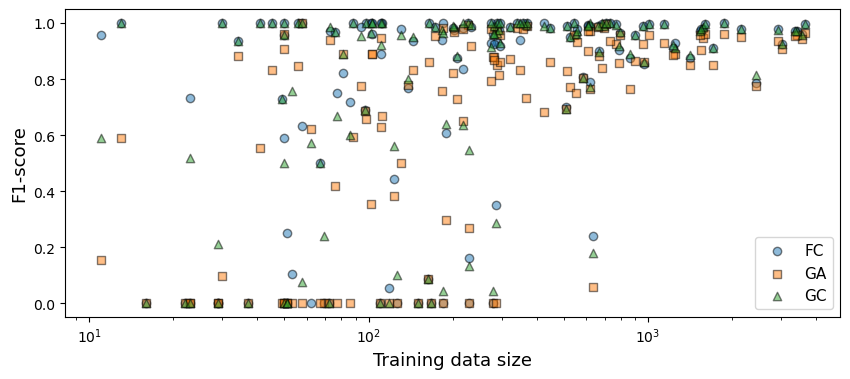

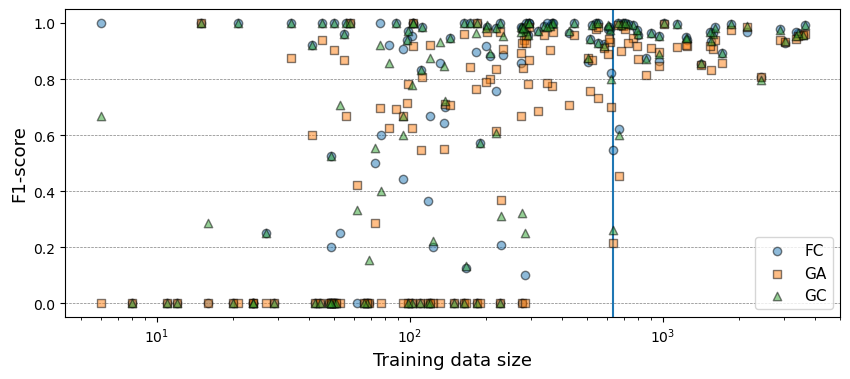

In [232]:
f1, ax1 = plt.subplots(1,1,figsize=(10,4))
f2, ax2 = plt.subplots(1,1,figsize=(10,4))
for i, (archi, data) in enumerate(mat.items()):
    for ax, (ds, dat) in zip([ax1, ax2], data.items()):
        label = np.array(mat[archi][ds]).T[0]
        n_tr, n_v, n_te = np.array([counter[l] for l in label]).T
        if ds == 'valid':
            m = (n_v != 0) & (n_v > 10)
        else:
            m = (n_te != 0) & (n_te > 5)
        true_count, prec, rec, f1 = np.array(mat[archi][ds])[m].T[1:].astype(float)
        ax.scatter(n_tr[m], f1, marker=['o','s','^'][i], color=plt.cm.tab10(i), alpha=0.5, edgecolors=[0,0,0], label=archi, zorder=10)
        ax.set_xscale('log')
        ax.legend(loc='lower right', fontsize=11)
        ax.set_ylabel('F1-score', fontsize=13)
        ax.set_xlabel('Training data size', fontsize=13)
for i in range(5):
    ax2.axhline(i * 0.2, ls='--', color=[0.5, 0.5, 0.5], lw=0.5, zorder=0)
ax2.axvline(634)

In [224]:
m = targets['valid'] == 7
for model in ['fcnn_active_composit_batch_0128_mdim_08_128_2',
              'attention_mat2vec_batch_0128_mdim_08_256_2',
              'convolution_oliynyk_batch_0128_mdim_08_128_2',]:
    m1 = predictions[model]['valid'] == 36
#    print(np.array(target_precursor_comps['valid'])[m & m1])
    print(np.unique(predictions[model]['valid'][m], return_counts=True))
    
label_comp_mapper[36],label_comp_mapper[59],label_comp_mapper[103]

(array([  7,  36,  59, 103]), array([236,  38,   3,   1]))
(array([ 7, 36, 59]), array([251,  10,  17]))
(array([ 7, 36, 59]), array([257,  18,   3]))


('C-O-Mn', 'Mn', 'H-C-O-Mn')

In [211]:
for k1, v1 in dct.items():
    for k2, v2 in v1.items():
        print(k1, k2, '\t', ' '.join([f'{v:.3f}' for v in v2['C-O-Mn'][1:]]), ' '.join([f'{v:.3f}' for v in v2['Mn'][1:]]))

FC valid 	 0.310 0.196 0.240 0.962 0.990 0.976
FC test 	 0.615 0.492 0.547 0.958 0.958 0.958
GA valid 	 0.214 0.033 0.057 0.800 0.832 0.816
GA test 	 0.889 0.123 0.216 0.776 0.792 0.784
GC valid 	 0.367 0.120 0.180 0.962 0.990 0.976
GC test 	 0.579 0.169 0.262 0.958 0.958 0.958


{'None': {'Se_1.00000': 989,
  'S_1.00000': 787,
  'H_0.50000 N_0.08333 O_0.33333 P_0.08333': 587,
  'H_0.56250 N_0.12500 O_0.25000 P_0.06250': 264,
  'P_1.00000': 196,
  'C_1.00000': 131,
  'O_0.71429 P_0.28571': 144,
  'H_0.37500 O_0.50000 P_0.12500': 83,
  'H_0.66667 N_0.16667 Cl_0.16667': 45,
  'P_0.28571 S_0.71429': 17,
  'P_0.28571 Se_0.71429': 10,
  'H_0.66667 N_0.16667 F_0.16667': 29,
  'O_0.66667 Se_0.33333': 25,
  'I_1.00000': 21,
  'H_0.66667 C_0.22222 O_0.11111': 18,
  'H_0.53333 N_0.13333 O_0.26667 S_0.06667': 15,
  'H_0.28571 O_0.57143 S_0.14286': 9,
  'H_0.60000 N_0.15000 O_0.20000 P_0.05000': 9,
  'O_0.80000 P_0.20000': 4,
  'H_0.62500 N_0.12500 F_0.25000': 5,
  'P_0.40000 S_0.60000': 3,
  'H_0.45455 N_0.09091 O_0.36364 P_0.09091': 3,
  'H_0.34615 N_0.07692 O_0.46154 P_0.11538': 3,
  'H_0.27273 N_0.04545 O_0.54545 P_0.13636': 4,
  'H_0.66667 C_0.16667 O_0.16667': 4,
  'H_0.37500 C_0.37500 O_0.25000': 4,
  'H_0.64286 C_0.21429 S_0.07143 I_0.07143': 4,
  'H_0.25000 C_0.25

In [240]:
#f1, ax1 = plt.subplots(1,1,figsize=(10,4))
#f2, ax2 = plt.subplots(1,1,figsize=(10,4))
for i, (archi, data) in enumerate(mat.items()):
    arr = np.array(mat[archi]['valid']).T
    label = arr[0]
    count = np.array([counter[l] for l in label]).T
    true_count, prec, rec, f1 = arr[1:].astype(float)
#    for ax, (ds, dat) in zip([ax1, ax2], data.items()):
#        label = np.array(mat[archi][ds]).T[0]
#        n_tr, n_v, n_te = np.array([counter[l] for l in label]).T
#        if ds == 'valid':
#            m = (n_v != 0) & (n_v > 10)
#        else:
#            m = (n_te != 0) & (n_v > 10)
#        true_count, prec, rec, f1 = np.array(mat[archi][ds])[m].T[1:].astype(float)
#        ax.scatter(n_tr[m], f1, marker=['o','s','^'][i], color=plt.cm.tab10(i), alpha=0.5, edgecolors=[0,0,0], label=archi, zorder=10)
#        ax.set_xscale('log')
#        ax.legend(loc='lower right', fontsize=11)
#        ax.set_ylabel('F1-score', fontsize=13)
#        ax.set_xlabel('Training data size', fontsize=13)
#for i in range(5):
#    ax1.axhline(i * 0.2, ls='--', color=[0.5, 0.5, 0.5], lw=0.5, zorder=0)
#ax1.axvline(634)

In [262]:
for mele in MetalElements:
    m1 = np.array([mele in l.split('-') for l in label])
    m2 = count[1] > 10
    if np.sum(m1 & m2) == 0:
        continue
    print(mele)
    for i in np.where(m1 & m2)[0]:
        print(f'{label[i]:>20s} {count.T[i].sum():5d} {f1[i]*100:7.3f} ')

Li
              Li-C-O  1932  88.789 
              H-Li-O   344  28.571 
                Li-O   102  24.000 
                Li-F    96  66.667 
                  Li    66  50.000 
B
                 B-O   314  63.736 
               H-B-O   280  54.795 
                   B   111 100.000 
Na
              C-O-Na  1814  92.169 
                  Na   163  95.455 
                F-Na    87  50.000 
            H-O-Na-P    75  75.862 
                O-Na    68   0.000 
              O-Na-P    60   0.000 
Mg
                O-Mg  1406  86.213 
                  Mg   429  98.630 
            H-C-O-Mg   235   4.348 
              C-O-Mg   181   0.000 
Al
                O-Al  1845  91.154 
                  Al   702  96.175 
              H-O-Al   194   0.000 
Si
                O-Si  2028  97.340 
                  Si   355  96.104 
                N-Si   224  64.000 
Ca
              C-O-Ca  3802  92.505 
                O-Ca   351   4.255 
                  Ca   114  98.551 
        

In [26]:
from src.feature import feature_to_composit, feature_to_ligand_index, ligand_composit_feature, ligand_label, ligand_index, ligand_vector
from src.utils import find_nearest, squared_error, cosin_similarity
from sklearn.metrics import confusion_matrix

prd = output['conv_active_composit_batch_0256_mdim_16_032_2_case_09']['valid']['pred']
inp = output['conv_active_composit_batch_0256_mdim_16_032_2_case_09']['valid']['input']

inp_lbls = []
prd_lbls = []
for i, p in zip(inp, prd):
    i_i, sser, csim = find_nearest(i.reshape(1,-11), ligand_vector)
    i_p, sser, csim = find_nearest(p.reshape(1,-11), ligand_vector)
    inp_lbls.append(i_i[0])
    prd_lbls.append(i_p[0])
cm = confusion_matrix(inp_lbls, prd_lbls)

In [43]:
for i, (idx, cnt) in enumerate(zip(*np.unique(inp_lbls+prd_lbls, return_counts=True))):
#    print(ligand_index[idx], cnt, cm[i,i] / cm[i].sum(), cm[i,i] / cm[:,i].sum())
    print('{:15s} {:10d} ({:.5f}) {:10d} ({:.5f})'.format(ligand_index[i], cm[i].sum(), cm[i].sum()/len(inp_lbls), cm[:, i].sum(), cm[:, i].sum()/len(inp_lbls)))
#for i in range(79):
#    print('{:15s} {:10.0f} {:8.4f} {:8.4f}'.format(ligand_index[i], cm[i, i], cm[i, i] / cm[i].sum(), cm[i, i] / cm[:, i].sum()))

Metal-O               8486 (0.42915)       9203 (0.46541)
Metal-C-O             2493 (0.12607)       2393 (0.12102)
Metal                 7103 (0.35921)       7803 (0.39461)
Metal-H-O              144 (0.00728)          0 (0.00000)
Metal-N-O               95 (0.00480)          0 (0.00000)
Se                     294 (0.01487)          0 (0.00000)
H-N-O-P                189 (0.00956)        126 (0.00637)
S                      203 (0.01027)          0 (0.00000)
Metal-H-C-O             81 (0.00410)          0 (0.00000)
Metal-F                147 (0.00743)          0 (0.00000)
Metal-S                140 (0.00708)         28 (0.00142)
Metal-N                 36 (0.00182)          0 (0.00000)
Metal-Cl                37 (0.00187)          0 (0.00000)
Metal-H-N-O             53 (0.00268)          0 (0.00000)
Metal-O-P               39 (0.00197)          0 (0.00000)
Metal-H-O-P             32 (0.00162)          0 (0.00000)
P                       33 (0.00167)        110 (0.00556)
Metal-Se      

In [236]:
tol = 0.5
input_index = np.array(feature_to_ligand_index(o['input']))
pred_index = np.array(feature_to_ligand_index(o['pred'], tol=0.5))
input_label = np.array([ligand_index[i] for i in input_index])
pred_label = np.array([ligand_index[i] if i != -1 else 'Fail' for i in pred_index])

In [244]:
import gzip, pickle
with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
    unique_ligand = pickle.load(f)
unique_ligand

{('O',): {'count': 86539,
  'metals': {('Y',): {'count': 3101,
    'case': [{'composition': {'Y': 0.4, 'O': 0.6},
      'years': [1979,
       1979,
       1986,
       1995,
       1995,
       1996,
       1996,
       1996,
       1996,
       1997,
       1997,
       1997,
       1997,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1998,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       1999,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
       2000,
      

In [102]:
ligands = {}
precursors = {}
for ligand, _ligand_data in unique_ligand.items():
    for metal, _metal_data in _ligand_data['metals'].items():
        precursor = metal, ligand
        c = _metal_data['count']
        if len(metal) == 0:
            if precursor not in ligands.keys():
                ligands[precursor] = 0
                precursors[precursor] = 0
            ligands[precursor] += c
            precursors[precursor] += c
        else:
            if precursor not in precursors.keys():
                precursors[precursor] = 0
            if (('Metal',), ligand) not in ligands.keys():
                ligands[(('Metal',), ligand)] = 0
            ligands[(('Metal',), ligand)] += c
            precursors[precursor] += c
ligands = {k:v for k,v in sorted(ligands.items(), key=lambda x: x[1], reverse=True)}
precursors = {k:v for k,v in sorted(precursors.items(), key=lambda x: x[1], reverse=True)}
ligands.update({((),()):0})

precursors.update({((),()):0})


In [107]:
from src.feature import active_composit_feature, ligand_composit_feature

ligand_vector = np.vstack([ligand_composit_feature({e if e != 'Metal' else 'Li':1 for e in k[0] + k[1]}, dtype=float) for k in ligands.keys()])
precursor_vector = np.vstack([active_composit_feature({e:1 for e in k[0] + k[1]}, dtype=float) for k in precursors.keys()])

def parse_feature(feat_vec, csim_cut = 0.5, sser_cut = 1.0, to_string=False):
    out = []
    if feat_vec.shape[-1] == 12:
        ref = ligand_vector
        chrs = np.array(['-'.join(k[0] + k[1]) for k in ligands.keys()] + ['Unknown'])
    elif feat_vec.shape[-1] == 97:
        ref = precursor_vector
        chrs = np.array(['-'.join(k[0] + k[1]) for k in precursors.keys()] + ['Unknown'])
    else:
        raise ValueError('Not supported feature type')

    for idx, sser, csim in zip(*find_nearest(feat_vec, ref)):
        if (sser > sser_cut) or (csim < csim_cut):
            out.append(-1)
        else:
            out.append(int(idx))
    if to_string:
        return chrs[out]
    else:
        return out
    

_inp_lbls = parse_feature(inp)
_prd_lbls = parse_feature(prd)

In [36]:
pred_index[4554], input_index[4554]

(0, 0)

In [49]:
for i_inp in sorted(np.unique(input_index), key=lambda x: ligand_index[x]):
    m = input_index == i_inp
    a = np.sum(pred_index[m] == i_inp)
    t = np.sum(m)
    print('{:15s} {:5d} {:5d} {:8.3f}'.format(ligand_index[i_inp], t, a, 100*a/t))
    
#    print(sorted(zip(*np.unique(np.array(pred_label)[m], return_counts=True)), key=lambda x: x[1], reverse=True))

C                   7     7  100.000
H-C-N-O             2     0    0.000
H-C-O               6     0    0.000
H-C-S-Br            3     0    0.000
H-C-S-Cl            3     0    0.000
H-C-S-I             4     0    0.000
H-N-Cl             19    12   63.158
H-N-F               2     0    0.000
H-N-O-P            18    18  100.000
H-N-O-S             5     0    0.000
H-O-P               8     0    0.000
Metal            1518  1466   96.574
Metal-Br           10     2   20.000
Metal-C             4     0    0.000
Metal-C-O        1572  1448   92.112
Metal-C-S           1     0    0.000
Metal-Cl           23     5   21.739
Metal-F            36    14   38.889
Metal-H-C-N-Br      1     0    0.000
Metal-H-C-N-Cl      1     0    0.000
Metal-H-C-N-I       1     0    0.000
Metal-H-C-O        90     0    0.000
Metal-H-F           1     0    0.000
Metal-H-N-O        28     3   10.714
Metal-H-O          97    15   15.464
Metal-H-O-P        10     0    0.000
Metal-H-O-S         2     0    0.000
M

In [66]:
import run_fcvae_class as R

#R.parser.parse_args('--logging')
#R.args
#R.logging = True
#R.epochs = 5
#R.main(R.args)

usage: ipykernel_launcher.py [-h] [--hidden_dim HIDDEN_DIM]
                             [--hidden_layers HIDDEN_LAYERS]
                             [--latent_dim LATENT_DIM]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS]
                             [--early_stop EARLY_STOP]
                             [--logging_interval LOGGING_INTERVAL]
                             [--target_feature_type TARGET_FEATURE_TYPE]
                             [--logging]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/jhyang/.local/share/jupyter/runtime/kernel-v2-245045jJs10vwAO5mJ.json


SystemExit: 2

In [19]:
predictions = {}
for task in ['reg','cls']:
    for model in os.listdir(os.path.join(root_t, task)):
        model_type = model.split('_')[0]
#        print(model_type)
print(os.listdir(os.path.join(root_t, task, model)))
with open(os.path.join(root_t, task, model, 'output.valid.pkl'), 'rb') as f:
    out = pickle.load(f)
#out['label']
#out['input'].shape   

['model_decoder.model', 'epoch.txt', 'events.out.tfevents.1714524199.jhyangw22.2655570.38', 'output.test.pkl', 'model_encoder.model', 'output.valid.pkl']


array([{'Zn': 0.11111111, 'N': 0.22222222, 'O': 0.6666667},
       {'Fe': 0.11111111, 'N': 0.22222222, 'O': 0.6666667},
       {'Pb': 0.4, 'O': 0.6}, ..., {'Cr': 0.4, 'O': 0.6}, {'Al': 1.0},
       {'Mg': 1.0}], dtype=object)

In [45]:
precursors = np.hstack([info['precursor_comp'] for info in out['info']])
fracs = []
for i in range(np.max(out['label'])+1):
    comp, count = np.unique([str(p) for p in precursors[out['label'] == i]], return_counts=True)
    frac = count / np.sum(count)
    fracs.append((sorted(frac, reverse=True), np.sum(count)))
